In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(1, './Utils/')
import Diffusion as dm
import Plot

path_output_plots = '../Plots/'

config = dm.TrainingConfig()
config.DEVICE = 'cpu'

df = dm.DiffusionConfig(
    n_steps                 = config.TIMESTEPS,
    img_shape               = config.IMG_SHAPE, # Not used here
    device                  = config.DEVICE,
)

1it [00:00,  2.28it/s]/var/folders/9n/bd3rfvwx7vv0bqnmvrg9dtzr0000gp/T/ipykernel_18079/3625959245.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(part, x0, -x0, epsrel=1e-4)[0]
4it [00:00,  8.48it/s]
/var/folders/9n/bd3rfvwx7vv0bqnmvrg9dtzr0000gp/T/ipykernel_18079/3625959245.py:75: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(phi_num_d[i][0]/ts[i], phi_num_d[i][1], yerr=errs_d[i]*3, fmt='o',


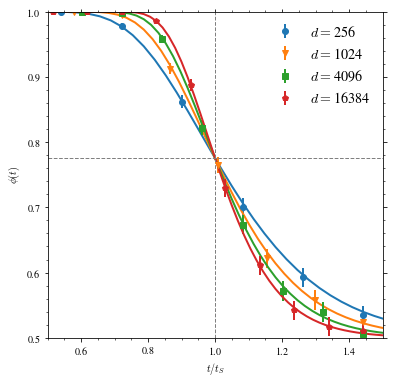

In [2]:
# Reproduces Fig. 2 of the paper
# Gaussian mixtures: speciation
# The numerical part is based on codes that can be found in
# the Python file "Gaussian_Mixutres_speciation.py"

from scipy import integrate
import numba as nb
from functools import partial
from tqdm import tqdm

plt.close('all')

# I) Theoretical part

@nb.njit(error_model="numpy",fastmath=True)
def gaussian(m, s, x):
    return 1/np.sqrt(2*np.pi*s) * np.exp(-(x-m)**2 / 2 / s)

@nb.njit(error_model="numpy",fastmath=True)
def integrand(m, s, t, x):
    dt = 1 - np.exp(-2*t)
    gt = dt+s*np.exp(-2*t)
    Gp = gaussian(m*np.exp(-t), gt, x)
    Gm = gaussian(-m*np.exp(-t), gt, x)
    itgrd = (Gp**2+Gm**2) / (Gp + Gm)
    return itgrd

ds = [256, 1024, 4096, 16384]
s = 1
m_tilde = 1
times = np.linspace(0, 9, 100)
ts = 1/2*np.log(np.array(ds))
phi = np.zeros((len(ds), len(times)))
for (i_d, d) in tqdm(enumerate(ds)):
    m = m_tilde * np.sqrt(d)
    for (it, t) in enumerate(times):
        c = m*np.exp(-t)
        x0 = -c-5*s
        part = partial(integrand, m, s, t)
        integral = integrate.quad(part, x0, -x0, epsrel=1e-4)[0]
        if np.isnan(integral):
            x0, x1, x2, x3 = -c-5*s, -c+5*s, c-5*s, c+5*s
            integral = integrate.quad(part, x0, x1, epsrel=1e-4)[0]
            integral += integrate.quad(part, x2, x3, epsrel=1e-4)[0]
        phi[i_d][it] = 1/2*integral

# II) Numerical part
path_data = '../Saves/Gaussian_mixtures/Speciation/'
nsamples = 10000    # should be the number run in '
phi_num_d = []
all_classes_d = []
errs_d = []
for d in ds:
    file1 = 'phi_num_d{:d}_n{:d}.npy'.format(d, nsamples)
    phi_num = np.load(path_data + file1)
    phi_num_d.append(phi_num)
    
    file2 = 'all_classes_d{:d}_n{:d}.npy'.format(d, nsamples)
    all_classes = np.load(path_data + file2)
    all_classes_d.append(all_classes)

    # Compute standard error
    errs = all_classes.std(0)/np.sqrt(nsamples)
    errs_d.append(errs)

# III) Plot
clrs = ['C0', 'C1', 'C2', 'C3']
markers = ['o', 'v', 's', 'p', 'D', '*']
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(ds)):
    # Theoretical curve
    ax.plot(times/ts[i], phi[i], lw=2, color=clrs[i])

    # Numerical experiment
    ax.errorbar(phi_num_d[i][0]/ts[i], phi_num_d[i][1], yerr=errs_d[i]*3, fmt='o',
                 lw=2, color=clrs[i], marker=markers[i],
                 label=r'$d=${:d}'.format(ds[i]))
    
ax.axvline(1, lw=1, color='grey', ls='--')
ax.axhline(0.7753, lw=1, color='grey', ls='--')

plt.legend(frameon=False, fontsize=14)
ax.set_xlim([0.5, 1.5])
ax.set_ylim([.5, 1])
ax.set_xlabel(r'$t/t_S$')
ax.set_ylabel(r'$\phi(t)$')

fig.savefig(path_output_plots + 'Speciation_GM.pdf', bbox_inches='tight')
plt.show()

/var/folders/9n/bd3rfvwx7vv0bqnmvrg9dtzr0000gp/T/ipykernel_18079/2695619804.py:35: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(tt, crit_N[i], errors_N[i]*3, color=clrs[i], fmt='o',


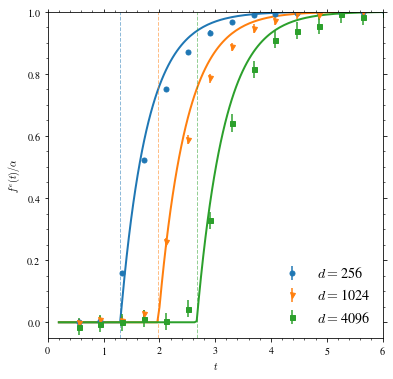

In [3]:
# Reproduces Fig. 3 of the paper
# Gaussian mixtures: collapse
# The numerical part is based on codes that can be found in
# the Python file "Gaussian_Mixutres_entropy.py"

Ns = [256, 1024, 4096]
P = 20000
mutilde = 1             # Order 1
sigma = 1    

WANT_COND_LINE = True
WANT_FILL_BETWEEN = False

path_data = '../Saves/Gaussian_mixtures/Collapse/'

# Load results from experiments
loading = np.load(path_data + 'f(t)_num_GM.npy')
tt = loading[0]
crit_N = loading[1:len(Ns)+1]
errors_N = loading[len(Ns)+1::]

loading = np.load(path_data + 'f(t)_theo.npy')
tt_theo = loading[0]
crit_theo_N = loading[1::]

clrs = ['C0', 'C1', 'C2', 'C3']
markers = ['o', 'v', 's', 'p', 'D', '*']
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(Ns)):
    tcond = 1/2 * np.log(1+sigma**2/(P**(2/Ns[i]) - 1))
    if WANT_FILL_BETWEEN:
        ax.fill_between(tt, crit_N[i]-errors_N[i]*3, crit_N[i]+errors_N[i]*3, 
                        alpha=0.2, color=clrs[i], label=r'$d=${:d}'.format(Ns[i]))
    else:
        ax.errorbar(tt, crit_N[i], errors_N[i]*3, color=clrs[i], fmt='o',
                    marker=markers[i], label=r'$d=${:d}'.format(Ns[i]),
                    markersize=5)
    
    # Theoretical curve
    ax.plot(tt_theo, crit_theo_N[i], lw=2)
    
    # Prediction condensation
    if WANT_COND_LINE:
        ax.axvline(tcond, color=clrs[i], lw=1.0, ls='--', alpha=0.5)
    
ax.set_xlim([0, 6])
ax.set_ylim([-.05, 1])
plt.legend(frameon=False, fontsize=14)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$f^e(t)/\alpha$')
plt.show()

fig.savefig(path_output_plots + 'Collapse_GM.pdf', bbox_inches='tight')

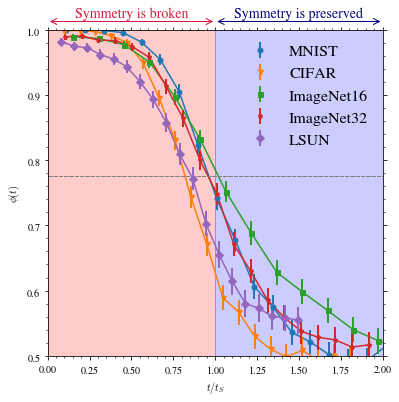

[7.66, 16.72, 3.05, 12.11, 60.52]
[1.01822639 1.41180229 0.55841851 1.25165176 2.0517602 ]
[0.96452955 0.82125852 1.02001698 0.96005096 0.86046677]


In [4]:
# Reproduces Fig. 4 of the paper
# Numerical experiment: speciation 
# This is based on the results from the code in
# the Python file "Experiment_symmetry_breaking.py"

times = np.array(list(range(config.TIMESTEPS, 0, -50)))

labels_datasets = ['MNIST', 'CIFAR', 'ImageNet16', 'ImageNet32', 'LSUN', 'CelebA']
datasets = ['MNIST', 'CIFAR', 'Imagenet16', 'Imagenet32', 'LSUN']#, 'CelebA64']
n_images_datasets = [10000, 3000, 1000, 1000, 20000, 20000] # Just for loading
n_data = len(datasets)

lambdas = [7.66, 16.72, 3.05, 12.11, 60.52]

# =================
# Load data
# =================
all_means = np.zeros((len(times), n_data))
all_stds = np.zeros((len(times), n_data))
all_err_m = np.zeros((len(times), n_data))
all_err_p = np.zeros((len(times), n_data))
estimate_tspec = np.zeros(n_data)
for i in range(n_data):
    filename = datasets[i] + '_' + str(n_images_datasets[i]) + '.npy'
    means, stds, err_m, err_p = np.load('../Saves/Exp_spec/'+filename)
    all_means[:, i] = means
    all_stds[:, i] = stds
    all_err_m[:, i] = err_m
    all_err_p[:, i] = err_p
    
    
# =================
# Plot
# =================
every = 1
t_specs = np.zeros(n_data, dtype=int)
t_specs_VP = np.zeros(n_data)
markers = ['o', 'v', 's', 'p', 'D', '*']
clrs = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel(r'$t/t_S$')
ax.set_ylabel(r'$\phi(t)$')
ax.set_ylim([1/2, 1])
ax.set_xlim([0, 2.])
ax.fill_betweenx([0, 1], 0, 1, color='red', alpha=.2)
ax.fill_betweenx([0, 1], 1, 2, color='blue', alpha=.2)
ax.annotate('', xy=(0, 1.025), xycoords='axes fraction', xytext=(.5, 1.025), 
            arrowprops=dict(arrowstyle="<->", color='crimson', mutation_scale=15))
ax.annotate('', xy=(0.5, 1.025), xycoords='axes fraction', xytext=(1, 1.025), 
            arrowprops=dict(arrowstyle="<->", color='navy', mutation_scale=15))
ax.annotate('Symmetry is broken', xy=(.25, 1.04), xycoords='axes fraction', xytext=(.25, 1.04),
            ha='center', fontsize=14, color='crimson')
ax.annotate('Symmetry is preserved', xy=(.25, 1.04), xycoords='axes fraction', xytext=(.75, 1.04),
            ha='center', fontsize=14, color='navy')
# ax.grid(True)
for i in range(0, n_data):
    means = all_means[:, i]
    std = all_stds[:, i]
    err_m = all_err_m[:, i]
    err_p = all_err_m[:, i]
    m = means[1::every]
    s = std[1::every]*3
    t = times[1::every]
    
    # Predicted t_spec
    t_spec = np.where(df.alpha_cumulative.cpu() < 1/(lambdas[i]))[0][0]
    t_spec_VP = -1/2*np.log(df.alpha_cumulative.cpu()[t_spec])
    
    # Estimate from phi(t) = 0.775
    thresh = 0.775
    times_plot = t/t_spec
    t_interp = np.linspace(times_plot[-1], times_plot[0], 1000)
    cs = np.interp(t_interp[::-1], times_plot[::-1], m[::-1])
    estimate_tspec[i] = t_interp[::-1][np.where(cs<0.775)[0][-1]]
    
    t_specs[i] = int(t_spec)
    t_specs_VP[i] = t_spec_VP
    ax.errorbar(times_plot, m, yerr=s, fmt=markers[i], lw=2, 
                color=clrs[i], label=labels_datasets[i], markersize=5)
    ax.plot(times_plot, m, '-', color=clrs[i], lw=1.5)
    ax.axhline(thresh, color='grey', ls='--', lw=1)
    
    ax.legend(frameon=False, loc='best', fontsize=16)

fig.savefig(path_output_plots + 'Symmetry_breaking_all_3std.pdf',
            bbox_inches='tight')
plt.show()

# Content of Table 1
print(lambdas)          # Largest eigenvalue
print(t_specs_VP)       # in time of the paper
print(estimate_tspec)   # in unit of t_S

234.2875
335.5
573.175


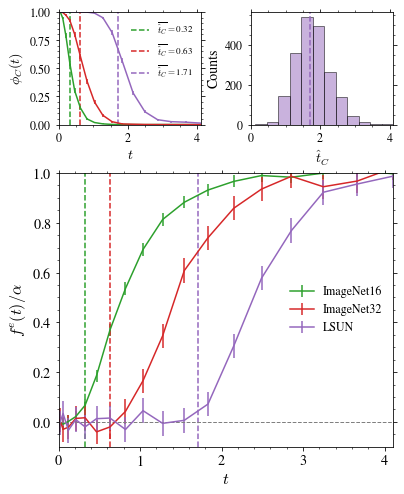

In [5]:
# Reproduces Fig. 5 of the paper
# Numerical experiment: collapse 
# This is based on the results from the code in
# the Python file "Experiment_collapse.py"

from matplotlib.gridspec import GridSpec
tmax = 900
clrs = ['C2', 'C3', 'C4']
times = np.array(list(range(config.TIMESTEPS, 0, -50)))[1::]

# Function to transform back the time (Eq. 59)
def transform_time(df, t):
    return -1/2*np.log(df.alpha_cumulative.cpu()[t]).numpy()

datasets = ['Imagenet16', 'Imagenet32', 'LSUN']
datasets_labels = ['ImageNet16', 'ImageNet32', 'LSUN']
Ns = np.array([3*16*16, 3*32*32, 3*64*64])
n_images = np.array([1000, 1000, 100])
Ps = 2*n_images     # n_images is number per class

estimate_tc = np.zeros((len(datasets), 2))      # From phi_C(t)
tc_hat = np.zeros(len(datasets))                # From histograms

fig = plt.figure(figsize=(6,8))
gs = GridSpec(6, 6, hspace=1.5, wspace=3.5)

# First part of the plot: phi_C(t) and histograms
ax = fig.add_subplot(gs[0:2, 0:3])
ax1 = fig.add_subplot(gs[0:2, 3::])
for i in range(len((datasets))):
    dset = datasets[i]
    P = Ps[i]
    n = n_images[i]
    N = Ns[i]
    alpha = np.log(P)/N
    
    # ----------------- Plot of histogram
    tcs = np.load('../Saves/Exp_collapse/times/tc_{:s}_{:d}.npy'.format(dset, n))
    print(tcs.mean())
    tcs = transform_time(df, tcs)
    tc_hat[i] = tcs.mean()
    if i == 2:
        t, c = np.unique(tcs, return_counts=True)
        ax1.hist(tcs, 12, fc=clrs[i], alpha=0.5, ec='k')
        ax1.axvline(tcs.mean(), color=clrs[i], lw=1.5, ls='--',
                    label=r'$\overline{\hat{t}_C} =$' + '{:.2f}'.format(tc_hat[i]))
    
    # ----------------- Plot of psi(t)
    psi = np.load('../Saves/Exp_collapse/phi_c/{:s}_{:d}.npy'.format(dset, n))
    
    t = transform_time(df, times)
    ax.errorbar(t, psi[1][1::], yerr=psi[2][1::]*3, 
                marker='None', lw=1.5, color=clrs[i], ls='-', markersize=5)
    ax.axvline(tcs.mean(), color=clrs[i], lw=1.5, ls='--',
                label=r'$\overline{\hat{t}_C} =$' + '{:.2f}'.format(tc_hat[i]))
    ax.legend(frameon=False, fontsize=9)
    
ax1.set_xlabel(r'$\hat{t}_C$', fontsize=14)
ax1.set_ylabel(r'Counts', fontsize=14)
ax1.set_xlim([0, transform_time(df, tmax)])

ax.set_xlabel(r'$t$', fontsize=14)
ax.set_ylabel(r'$\phi_C(t)$', fontsize=14)
ax.set_xlim([0, transform_time(df, tmax)])
ax.set_ylim([0, 1])

ax.tick_params(axis='both', which='both', labelsize=12)
ax1.tick_params(axis='both', which='both', labelsize=12)


# Second part: Entropy
ax = fig.add_subplot(gs[2::, :])
for i in range(len((datasets))):
    dset = datasets[i]
    P = Ps[i]
    n = n_images[i]
    N = Ns[i] 
    alpha = np.log(P)/N
    
    entropies = np.load('../Saves/Exp_collapse/Entropies/{:s}_{:d}.npy'.format(dset, n))
    
    t = transform_time(df, entropies[0])
    ax.errorbar(t, entropies[1]/alpha, yerr=entropies[2]*3/alpha, 
                marker='None', lw=1.5, color=clrs[i], ls='-', markersize=5,
                label=r'{:s}'.format(datasets_labels[i]))
    ax.axvline(tc_hat[i], color=clrs[i], lw=1.5, ls='--')
    
ax.axhline(0, color='grey', lw=1, ls='--')
ax.set_xlabel(r'$t$', fontsize=16)
ax.set_ylabel(r'$f^e(t)/\alpha$', fontsize=16)
ax.legend(frameon=False, fontsize=12)
ax.set_xlim([0, transform_time(df, tmax)])
ax.set_ylim([-0.1, 1])
    
ax.tick_params(axis='both', which='both', labelsize=14)

fig.savefig(path_output_plots + '/Collapse_ftalpha.pdf', bbox_inches='tight')
plt.show()